May 5: IDEALIZED: Bathymetry of an idealized canyon with the dimensions of Mackenzie canyon that will be used to test NEMO's performance at these scales.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [7]:
def plot_canyon(x, y, H):
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 2, 1)
    p = ax1.pcolormesh(x,y,H, cmap=cm.Spectral)
    fig.colorbar(p, ax=ax1)
    ax1.set_xlabel('Alongshore Distance')
    ax1.set_ylabel('Cross-shore Distance')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    X, Y = np.meshgrid(x, y)
    #ax2.plot_surface(X, Y, -1*H, cmap=cm.Spectral, linewidth=0, rstride=1, cstride=1, antialiased=False)
    ax2.plot_wireframe(X, Y, H, rstride=10, cstride=10)
    ax2.view_init(elev=30, azim=40)
    ax2.set_xlabel('Alongshore Distance')
    ax2.set_ylabel('Cross-shore Distance')
    ax2.set_zlabel('Depth')
    
    fig.subplots_adjust(wspace=0.01, hspace=None)

(Klinck, 1996; Kampf, 2007)
$$H(x,y) = H_D - \frac{1}{2} \big(H_D - H_S \big) \Bigg[ 1 - tanh \Big( \frac{y-y_0(x)}{y_c} \Big) \Bigg]$$
(Kampf, 2007)
$$y_0(x) = y_n + y_b \Bigg[ 1-\kappa e^{\frac{-(x - x_0)^2}{2b^2}} \Bigg]$$ 

* $H_D$ = maximum depth in domain
* $H_S$ = shelf depth
* $y_c$ = steepness of the continental slope
* $y_n$ = distance between head and coast
* $y_b$ = distance between head and shelf break
* $x_0$ = location of axis
* $b$ = canyon width

In [8]:
HD = 900/1000
HS = 80/1000
yn = 53688.918782184468/1000
yb = 86443.62324659928/1000
b = 55339.859052946638/1000
x0 = 155

yc_e = 0.033932095822522088 #steepness
yc_w = 0.015763602988544421
yc_e2 = 0.5 * (50000.0/1000) #half-width, east
yc_e3 = 0.5 * (44500.0/1000)
yc_w2 = 0.5 * (24596.7477525/1000) # half-width, west
yc_avg = 0.5 * (yc_e2 + yc_w2)

In [9]:
x = np.arange(0, 310, dtype=np.float)
y = np.arange(0, 310, dtype=np.float)
y0 = np.zeros((len(y),len(x)))
H = np.zeros((len(y),len(x)))
yc = yc_avg

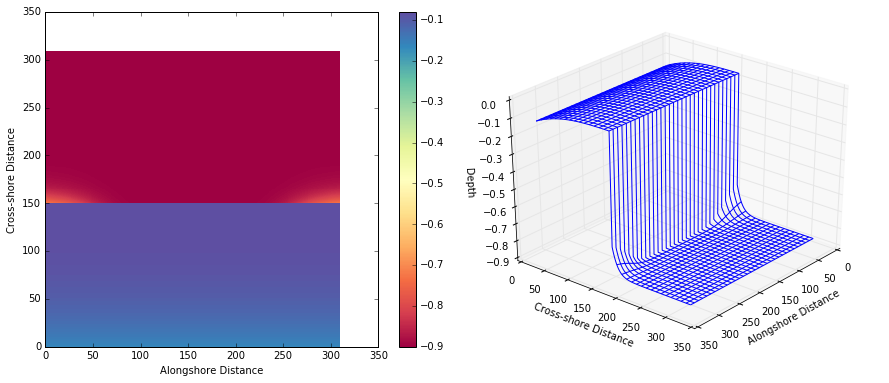

In [10]:
shelf_y = 150
ind = np.where(y==shelf_y)[0][0]

for lowerj in np.arange(0, ind+1):
    for i in range(len(x)):
        H[lowerj, i] = HS - (HS * ((y[lowerj] - shelf_y)/shelf_y)**3)
    
for upperj in np.arange(ind+1, len(y)):
    for i in range(len(x)):
        y0[upperj, i] = yn + (yb * (1 - np.exp((-1 * (x[i] - x0)**2) / (2*(b**2)))))
        H[upperj, i] = HD - 0.5 * (HD - HS)*(1 - np.tanh((y[upperj] - y0[upperj,i]) / yc))

plot_canyon(x, y, -1*H)

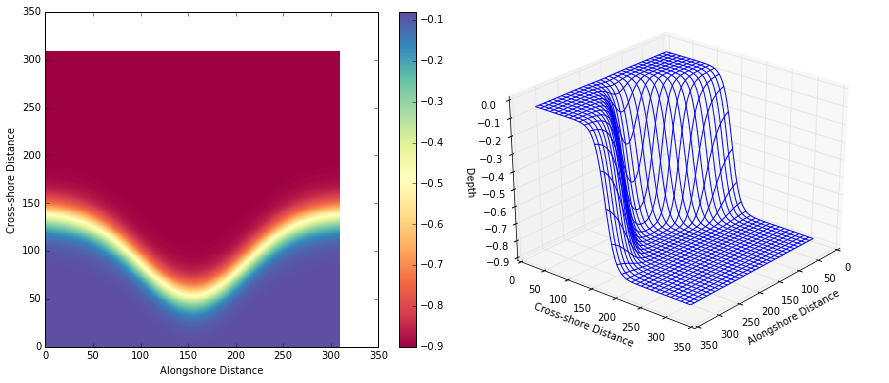

In [11]:
# Kampf, 2007
for j in range(len(y)):
    for i in range(len(x)):
        y0[j,i] = yn+(yb*(1-np.exp((-1*(x[i]-x0)**2)/(2*(b**2)))))
        H[j,i] = HD-0.5*(HD-HS)*(1-np.tanh((y[j]-y0[j,i])/yc))

plot_canyon(x, y, -1*H)

(Jordi et al, 2008)
$$H_S= 
\begin{cases}
    H_1-H_1\big(\frac{y-y_1}{y_1}\big)^3 & y\leq y_1\\
    H_1+\frac{1}{2}(H_2-H_1)\big[ 1+tanh\big(\frac{y-y_2}{L_1}\big) \big] & y> y_1
\end{cases}$$

$$H_C = H_S + max\big(0, H_3 \sqrt{\frac{y-y_3}{y_1-y_3}}-H_S\big)e^{\Big[-\Big(\frac{x-x_3}{L_2+\frac{\sqrt{y}}{L_3}}\Big)^2\Big]}$$

* $y_1$ = shelf position
* $y_2$ = slope position
* $y_3$ = canyon position
* $H_1$ = shelf depth
* $H_2$ = open ocean depth
* $H_3$ = canyon depth at mouth
* $L_1$ = slope width
* $L_2$ = canyon length
* $L_3$ = canyon width
* $x_3$ = alongshore canyon position

In [12]:
y1 = 20
y2 = 150
y3 = 50
H1 = HS
H2 = HD
H3 = 403.27197266/1000
L1 = 0.5*((2*yc_e2)+(2*yc_e3))
L2 = yb
L3 = b
x3 = x0

In [13]:
# Jordi, 2008
ind = np.where(y==y1)[0][0]
HS_new = np.zeros(len(y))

for lowerj in np.arange(0, ind+1):
    HS_new[lowerj] = H1 - (H1 * ((y[lowerj] - y1)/y1)**3)

for upperj in np.arange(ind+1, len(y)):
    HS_new[upperj] = H1 + (0.5 * (H2 - H1)) * (1 + np.tanh((y[upperj] - y2)/L1))
    
H = np.zeros((len(y),len(x)))
for j in range(len(y)):
    for i in range(len(x)):
        H[j,i] = HS_new[j] + (np.nanmax((H3 * (np.sqrt((y[j] - y3)/(y1 - y3)))) - HS)) * np.exp(-1 * ((x[i] - x3)/(L2 + (np.sqrt(y[j])/L3)))**2)

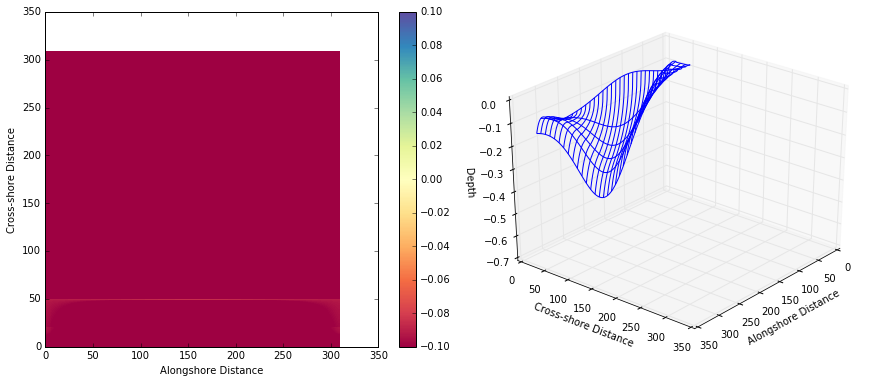

In [14]:
plot_canyon(x, y, -1*H)

(Klinck, 1996)
$$y_0(x) = y_n + y_b \Bigg[ 1-e^{\frac{-(x^2 - x_0^2)}{2b^2}} \Bigg]$$

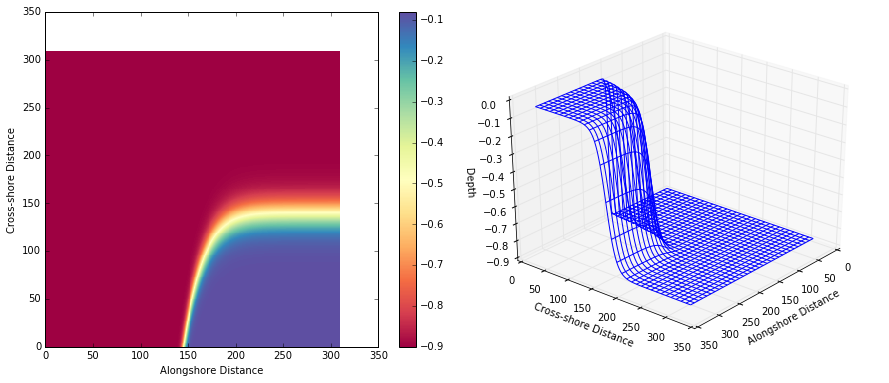

In [15]:
# Klinck, 1996 
for j in range(len(y)):
    for i in range(len(x)):
        y0[j,i] = yn+(yb*(1-np.exp((-1*(x[i]**2-x0**2))/(2*(b**2)))))
        H[j,i] = HD-0.5*(HD-HS)*(1-np.tanh((y[j]-y0[j,i])/yc))

plot_canyon(x, y, -1*H)

(She and Klinck, 2000)
$$H_s(y) = H_c - \big(H_{sb}-H_c\big) min\big(\frac{y}{y_{sb}},1\big) + \frac{1}{2} \big(H_{oc} - H_{sb} \big) \Bigg[ 1 + tanh \Big( \frac{y-y_{sl}(x)}{L_{sl}} \Big) \Bigg]$$

$$H(x,y) = H_s(y) + H_{can}(y) e^{\frac{-(x - x_c)^2}{2W(y)^2}} $$ 
$$W(y) = W_c(0.5 + \frac{y}{L_y})$$
$$H_{can}(y) = max(0., -H_s(y)+d_{can} \sqrt{\frac{y-y_c}{y_{sb}-y_c}})$$

* $H_c$ = depth of coastal wall
* $H_{sb}$ = depth at shelf break
* $H_{oc}$ = maximum depth
* $y_{sl}$ = location of middle of slope
* $L_{sl}$ = half-width of slope
* $y_{sb}$ = offshore distance of shelf break
* $y_c$ location of the head
* $x_c$ = location of canyon axis